In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [ ]:
HOUSING_PATH = "../datasets/housing.csv" 

In [35]:
def load_housing_data(housing_data_path=HOUSING_PATH):
    csv_path = housing_data_path
    return pd.read_csv(csv_path)

In [36]:
housing = load_housing_data()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


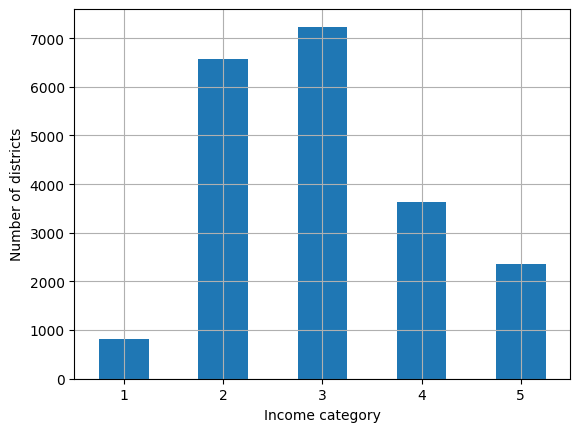

In [ ]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)


In [40]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

In [ ]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("ratio", FunctionTransformer(column_ratio, feature_names_out=ratio_name)),
        ("scale", StandardScaler())
    ])


class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, input_features=None):
        return [f"cluster_similarity_{i}" for i in range(self.n_clusters)]

log_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log, feature_names_out="one-to-one")),
    ("scale", StandardScaler())
])

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_ph", ratio_pipeline(), ["total_rooms", "households"]),
    ("pop_ph", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", ClusterSimilarity(n_clusters=10, gamma=1., random_state=42), ["latitude", "longitude"]),
    ("cat", cat_pipeline, ["ocean_proximity"]),
], remainder=Pipeline([("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]))


In [46]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
housing_predictions[:5].round(-2)
housing_labels.iloc[:5].values

array([103000., 382100., 172600.,  93400.,  96500.])

In [ ]:
from sklearn.model_selection import cross_val_score
forest_rmse = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmse).describe()

count       10.000000
mean     47080.261735
std       2124.249587
min      44346.191503
25%      45164.238375
50%      46898.061273
75%      49123.803053
max      49757.613215
dtype: float64

In [48]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42))
])

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions={
        "preprocessing__geo__n_clusters": randint(low=3, high=50),
        "random_forest__max_features": randint(low=2, high=20)
    }, n_iter=10, cv=3, scoring="neg_root_mean_squared_error", random_state=42
)

rnd_search.fit(housing, housing_labels)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'preprocessing__geo__n_clusters': <scipy.stats....001FEE30682B0>, 'random_forest__max_features': <scipy.stats....001FEE31FC050>}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'neg_root_mean_squared_error'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies th

In [53]:
final_model = rnd_search.best_estimator_
feature_importances = final_model["random_forest"].feature_importances_
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(np.float64(0.15233909920488806), 'log__median_income'),
 (np.float64(0.13342841781082834), 'remainder__income_cat'),
 (np.float64(0.055470856004873524), 'bedrooms__ratio'),
 (np.float64(0.05352996146328249), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.047528151090059104), 'pop_ph__ratio'),
 (np.float64(0.04096500123251192), 'geo__cluster_similarity_6'),
 (np.float64(0.03429668671029484), 'rooms_ph__ratio'),
 (np.float64(0.022119495939513692), 'geo__cluster_similarity_14'),
 (np.float64(0.02109779256533673), 'geo__cluster_similarity_23'),
 (np.float64(0.01985656320110141), 'geo__cluster_similarity_30'),
 (np.float64(0.017285606791829874), 'geo__cluster_similarity_43'),
 (np.float64(0.01654405880052141), 'geo__cluster_similarity_17'),
 (np.float64(0.016053391222066785), 'geo__cluster_similarity_38'),
 (np.float64(0.014795055852004697), 'geo__cluster_similarity_20'),
 (np.float64(0.014077407900749982), 'geo__cluster_similarity_41'),
 (np.float64(0.013201050402111409), 'geo__cluster_s

In [56]:
from sklearn.metrics import mean_squared_error
import math
X_test = test_set.drop("median_house_value", axis=1)
Y_test = test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = mean_squared_error(Y_test, final_predictions)
print(math.sqrt(final_rmse))

41745.64125066016


In [57]:
from scipy import stats
confidence = 0.95
squared_error = (final_predictions - Y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_error)-1, loc=squared_error.mean(), scale=stats.sem(squared_error)))

array([39632.64810082, 43756.71755713])

In [58]:
import joblib
joblib.dump(final_model, "california_housing_model.pkl")

['california_housing_model.pkl']